### Part. 2, Task A:

In [2]:
import pickle
import dynamiqs as dq
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import jax.numpy as jnp

### Compare Wigner function with ideal quantum states

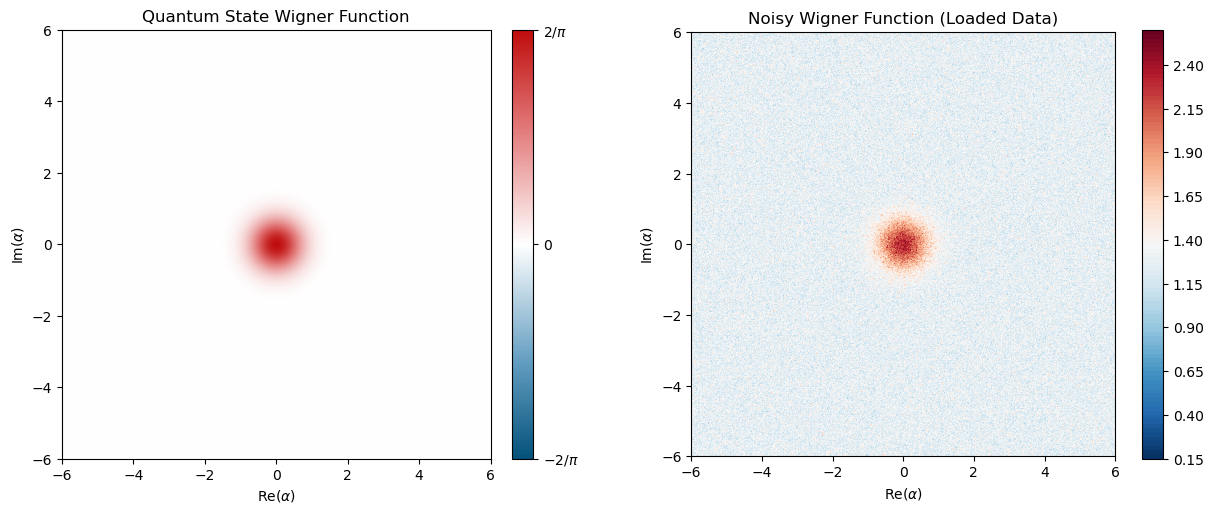

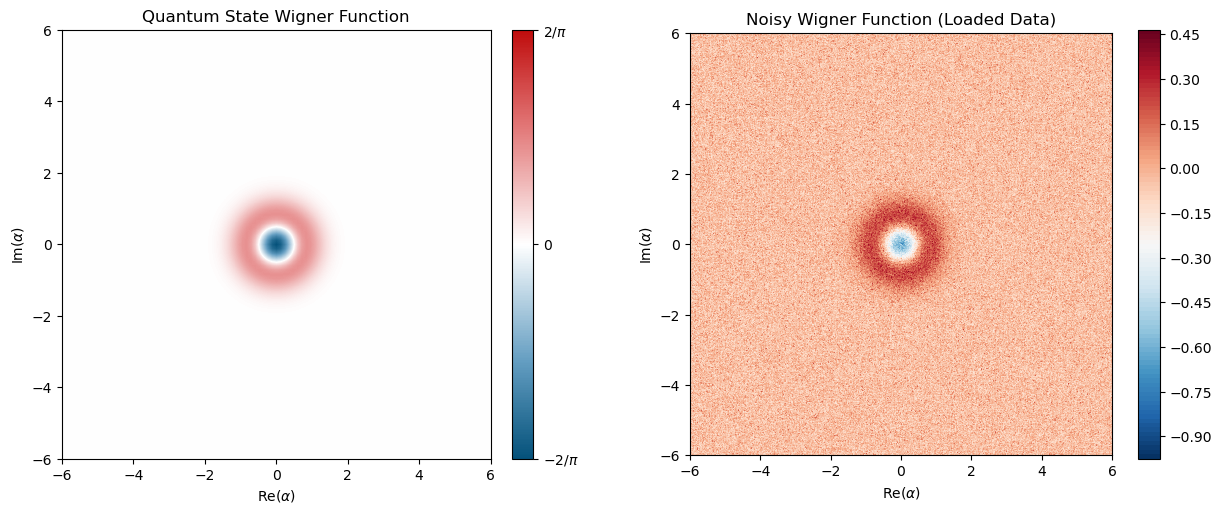

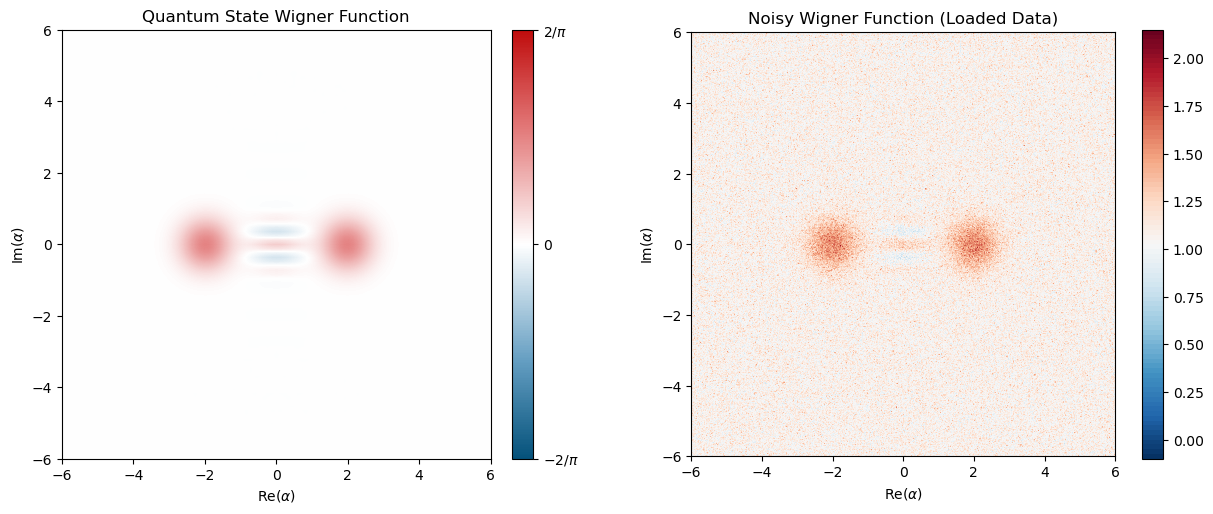

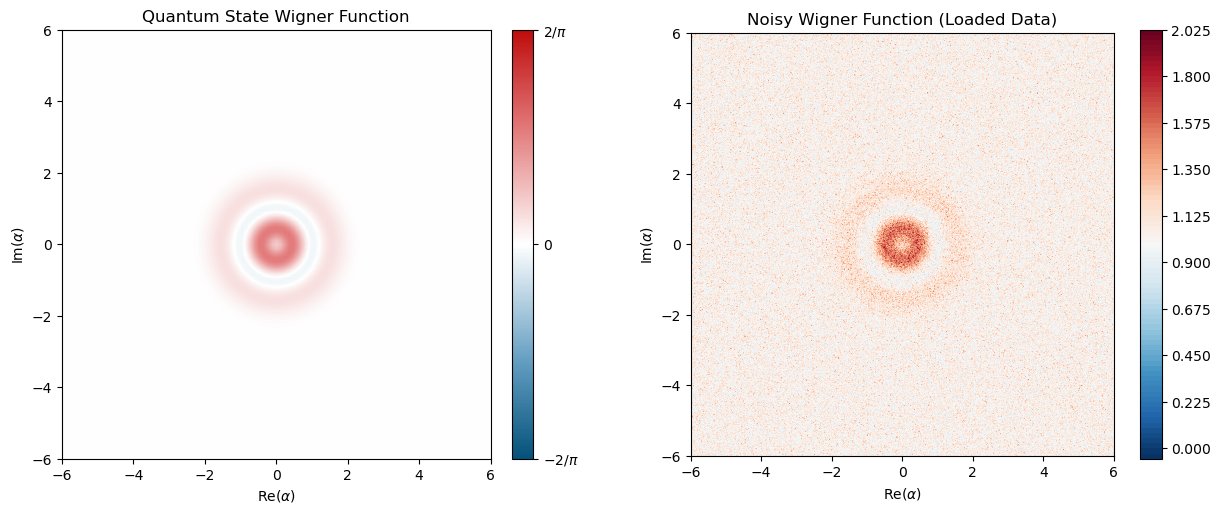

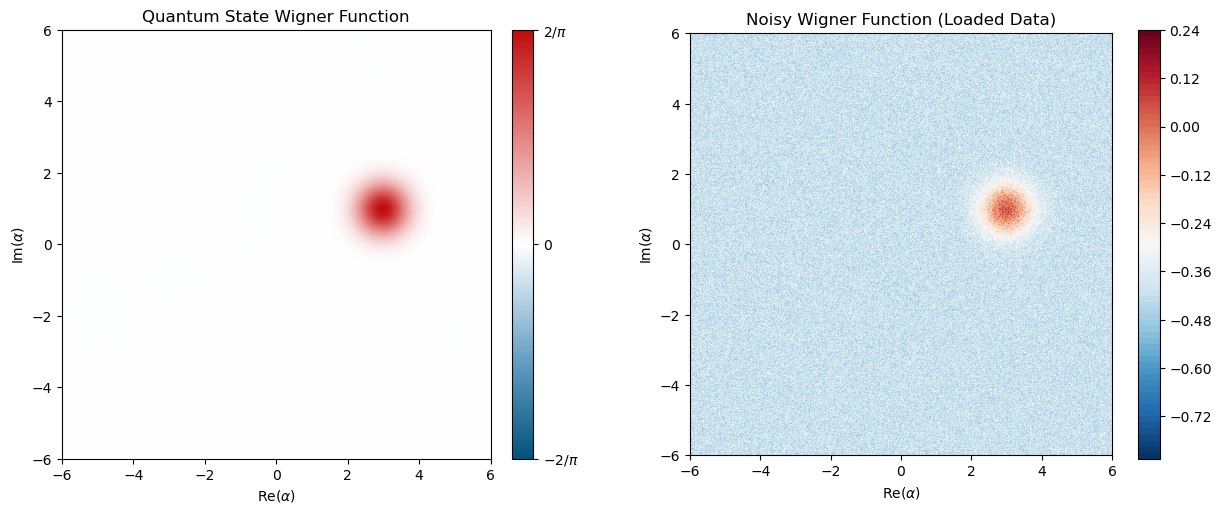

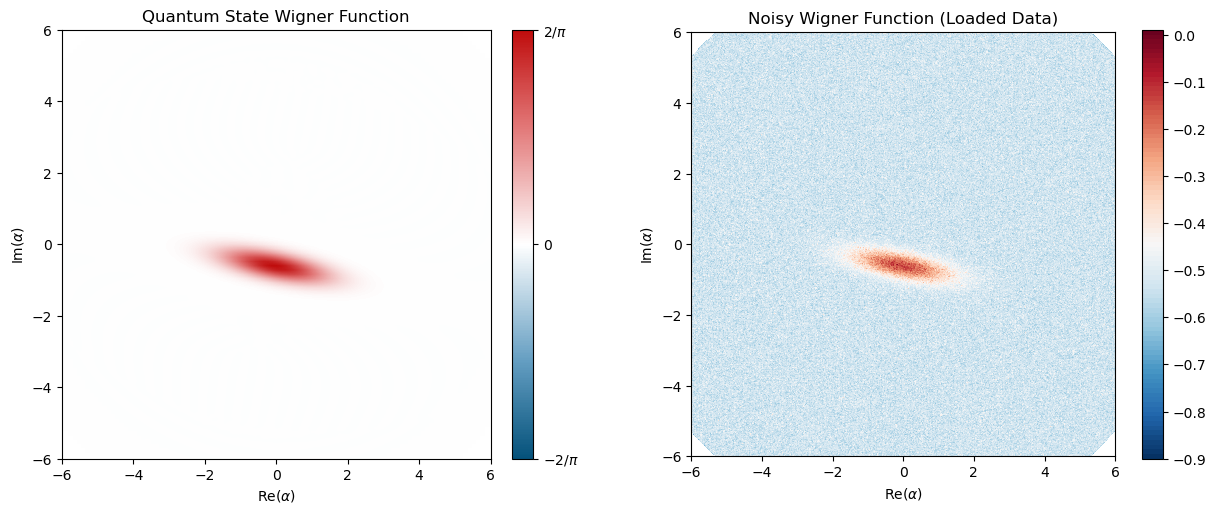

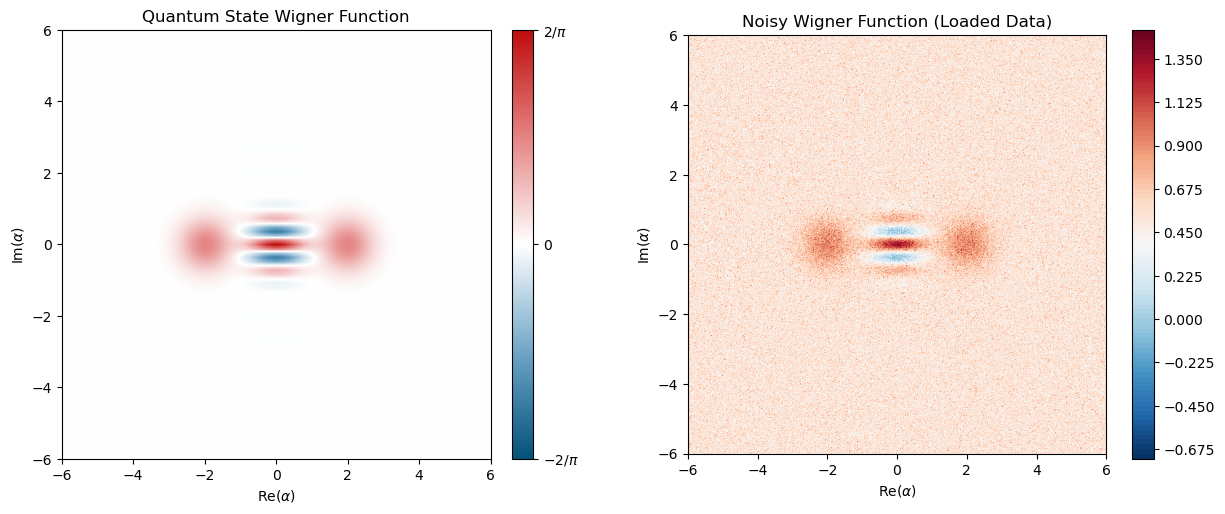

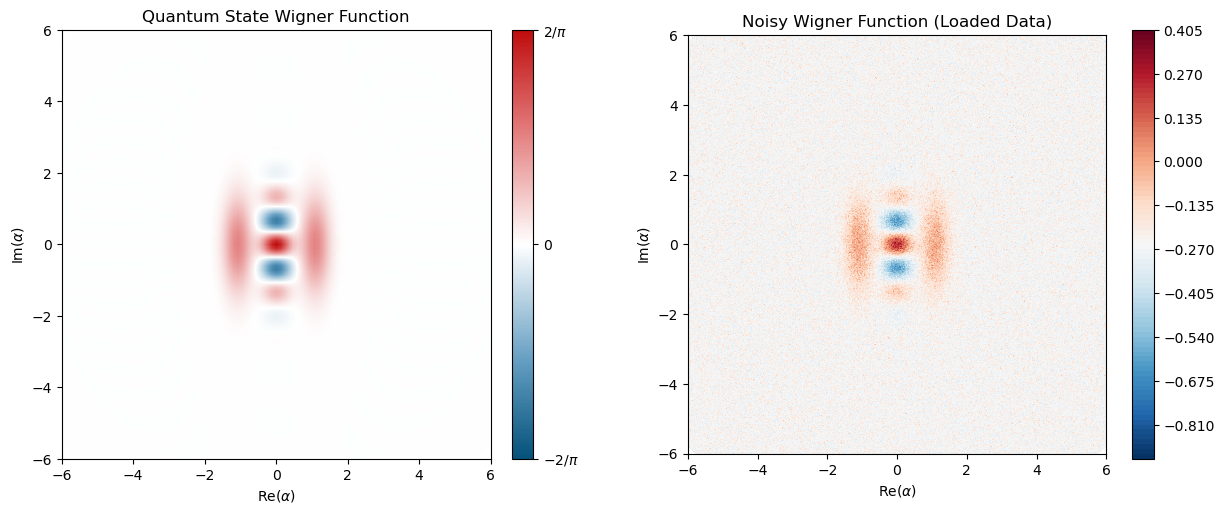

In [3]:
for i in range(8):

    # Path to noisy wigner function
    wigner_function_filename = f'data/synthetic/noisy_wigner_{i}.pickle'
    with open(wigner_function_filename, 'rb') as f:
        wigner_data = pickle.load(f)

    x_values, y_values, wigner_values = [np.array(part) for part in wigner_data]
        
    # Path to your pickle file
    quantum_state_filename = f'data/synthetic/quantum_state_{i}.pickle'

    # Open the file in binary-read mode and load
    with open(quantum_state_filename, 'rb') as f:
        quantum_state_data = pickle.load(f)
    
    # plot quantum state's wigner function
    fig, axs = plt.subplots(1, 2, figsize=(13, 5.5)) # Adjust figsize as needed
    dq.plot.wigner(quantum_state_data, ax=axs[0], xmax=6, ymax=6, colorbar=True)
    axs[0].set_title('Quantum State Wigner Function')
    axs[0].set_xlabel(r'Re($\alpha$)')
    axs[0].set_ylabel(r'Im($\alpha$)')
    axs[0].set_aspect('equal', adjustable='box') # Ensure square aspect ratio

    contour_plot = axs[1].contourf(x_values, y_values, wigner_values.T, levels=100, cmap='RdBu_r')

    # Add a colorbar for this contour plot
    cbar = fig.colorbar(contour_plot, ax=axs[1])

    axs[1].set_title('Noisy Wigner Function (Loaded Data)')
    axs[1].set_xlabel(r'Re($\alpha$)')
    axs[1].set_ylabel(r'Im($\alpha$)')
    axs[1].set_aspect('equal', adjustable='box') # Ensure square aspect ratio

    plt.tight_layout(pad=2.0) # Add some padding
    plt.show()


# Denoise data

We know that the Wigner function vanishes at infinity. In our case, we suppose that the actual Wigner function of the system vanishes near the edges of the phase space that we know is a 6 by 6 space. We then implement a circle that will separate the space in two areas, the one in the center where the actual Wigner function is most kikely to be non-zero and the other one where the actual Wigner function vanished. In the region, the measured Wigner function is constant and equal to b + noise. Averaging over this surface will give us b as the noise averages to zero.

- step 1: average points on the edges to find the bias b
- step 2: integrate over the unbiased data, this gives the sacling factor a
- step 3: apply $W_{corrected} = \frac{W_{initial}-b}{a}$ 
- step 4: apply a 2D gaussian filter

In [7]:
def integral_2d(dx, dy, z):
    return dx * dy * np.nansum(z)

def rescale_wigner(x_values, y_values, wigner_values):
    mask_not_nan = ~np.isnan(wigner_values)

    #estimate b from outside a circle and a from normalization
    X, Y = np.meshgrid(x_values, y_values, indexing='xy')
    radius = 5.5
    mask = (X**2 + Y**2) >= radius**2
    mask &= mask_not_nan

    b = np.mean(wigner_values[mask])
    dx = x_values[1] - x_values[0]
    dy = y_values[1] - y_values[0]
    a = integral_2d(dx, dy, wigner_values[mask_not_nan] - b)

    #affine correction
    corrected_wigner = np.nan_to_num((wigner_values - b) / a)

    #apply 2D Gaussian filter
    return corrected_wigner,a,b

def get_denoising_fidelity(
    wigner_data: np.ndarray,
    x_values : np.ndarray,
    y_values: np.ndarray,
    noiseless_quantum_state: dq.QArrayLike
    ):
    
    x_jax = jnp.asarray(x_values)
    y_jax = jnp.asarray(y_values)

    # Compute Wigner function using Dynamiqs
    _,_, true_wigner = dq.wigner(noiseless_quantum_state, xvec=x_jax, yvec=y_jax)
    true_wigner = jnp.nan_to_num(true_wigner)

    dx = x_values[1] - x_values[0]
    dy = y_values[1] - y_values[0]
    fidelity = jnp.pi * jnp.sum(true_wigner* wigner_data) * dx * dy

    return float(fidelity)

fidelity unbiased = 0.9873982071876526, fidelity after filtering = 0.9873982071876526
Case 0:  sacling a = 1.675e+00, bias b = 1.041e+00


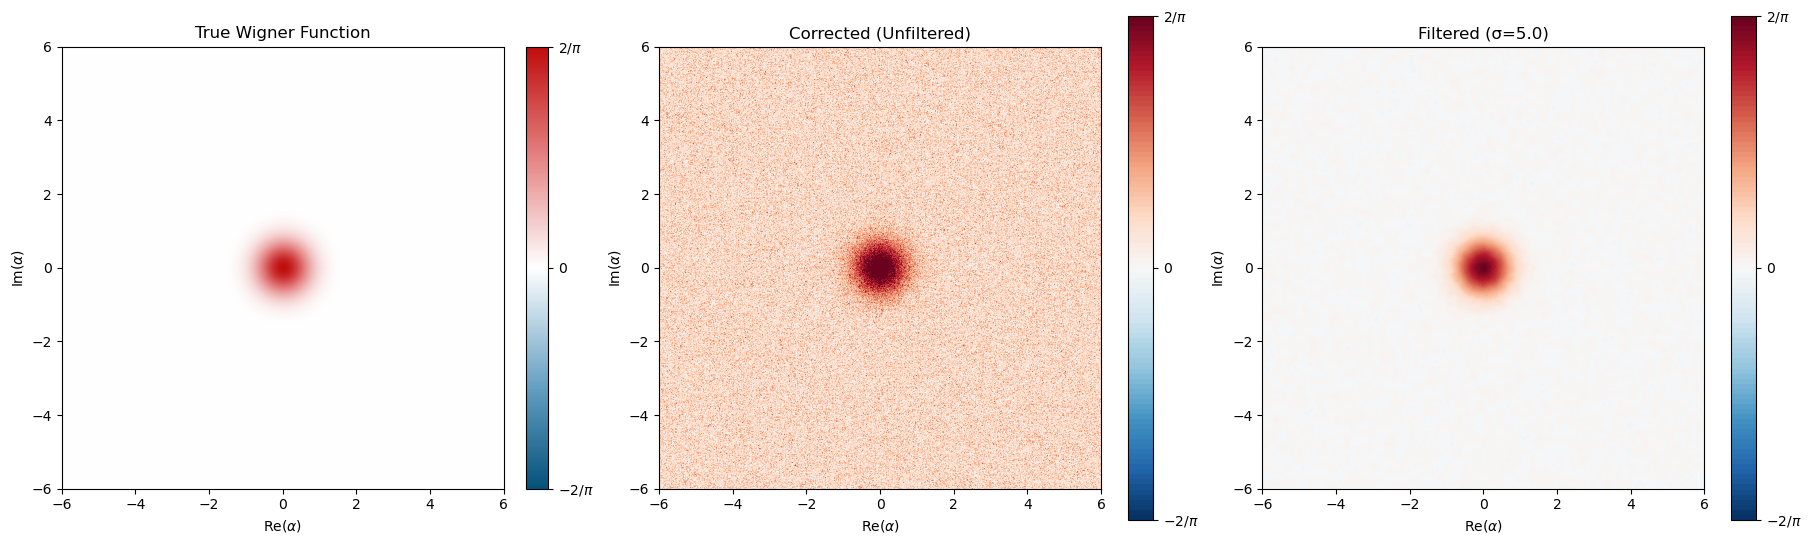

fidelity unbiased = 1.020188570022583, fidelity after filtering = 1.020188570022583
Case 1:  sacling a = 8.869e-01, bias b = -1.556e-01


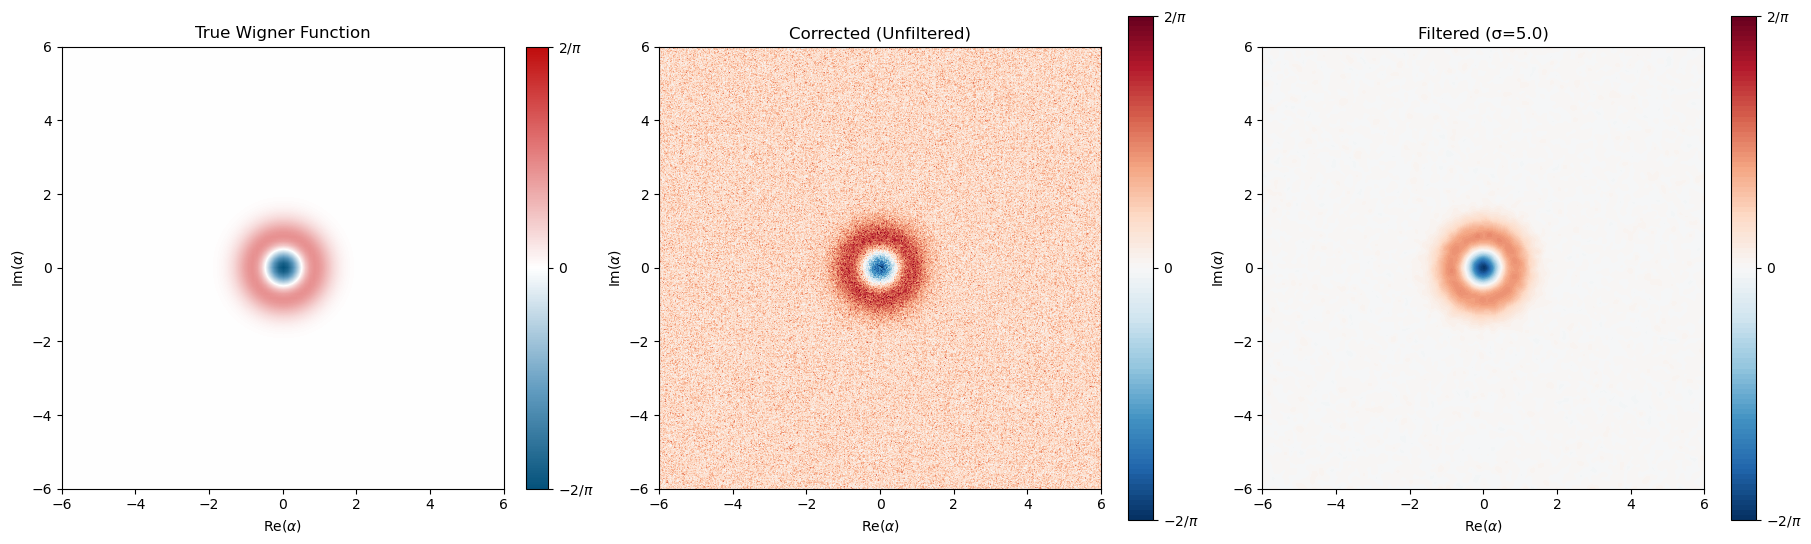

fidelity unbiased = 0.5362516045570374, fidelity after filtering = 0.5362516045570374
Case 2:  sacling a = 1.488e+00, bias b = 8.619e-01


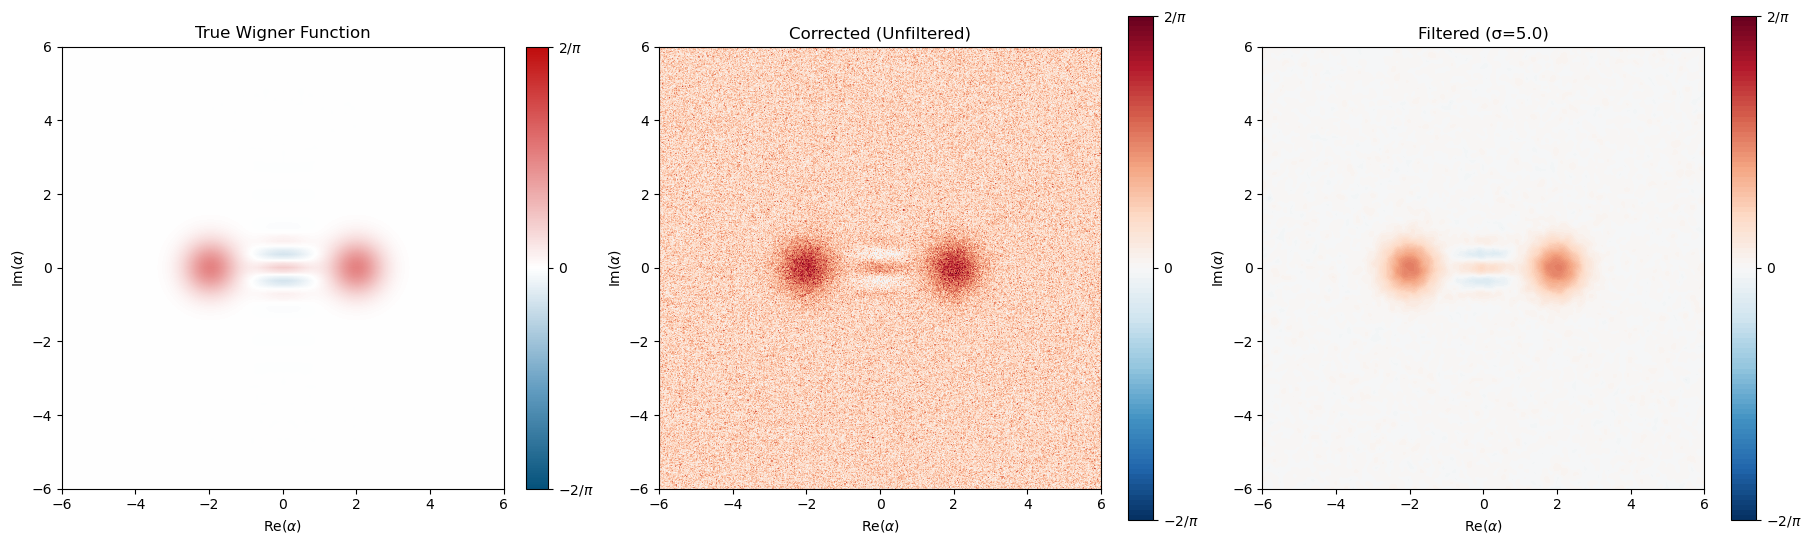

fidelity unbiased = 0.5209534764289856, fidelity after filtering = 0.5209534764289856
Case 3:  sacling a = 1.513e+00, bias b = 8.263e-01


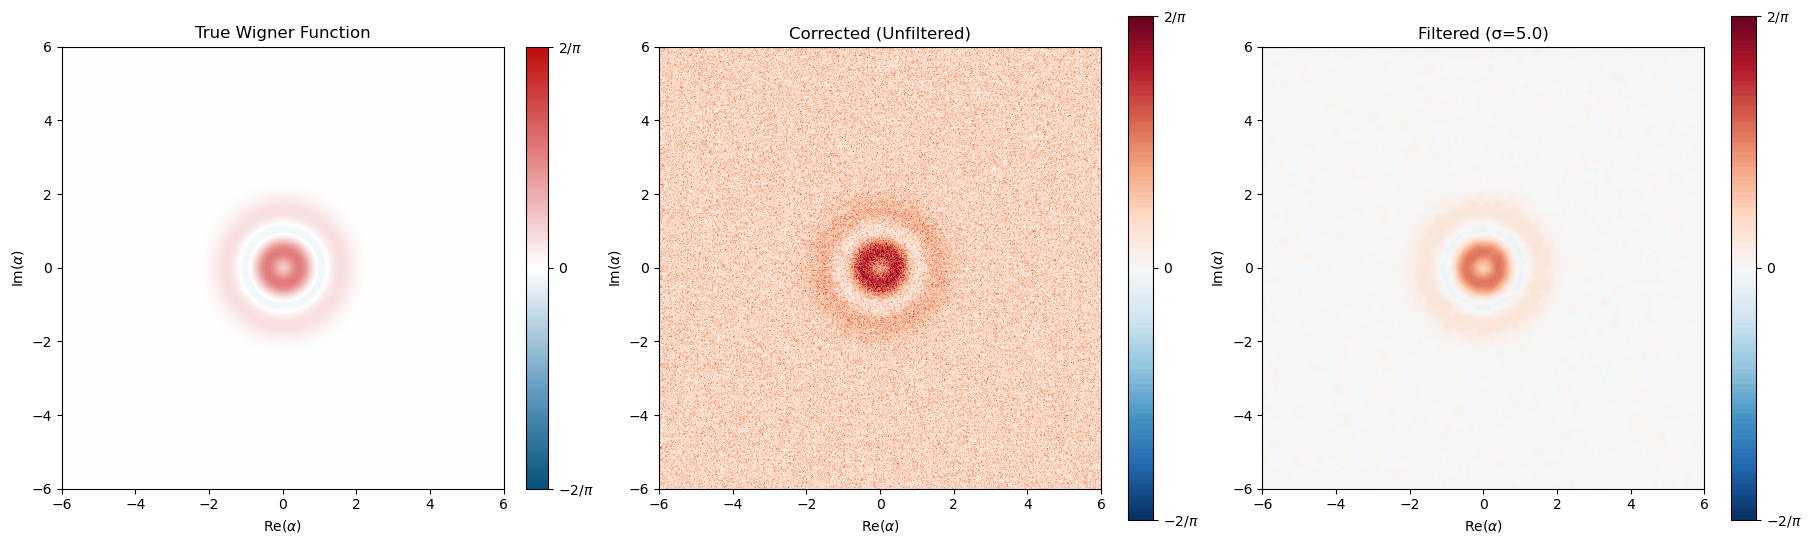

fidelity unbiased = 0.9966222047805786, fidelity after filtering = 0.9966222047805786
Case 4:  sacling a = 6.903e-01, bias b = -4.923e-01


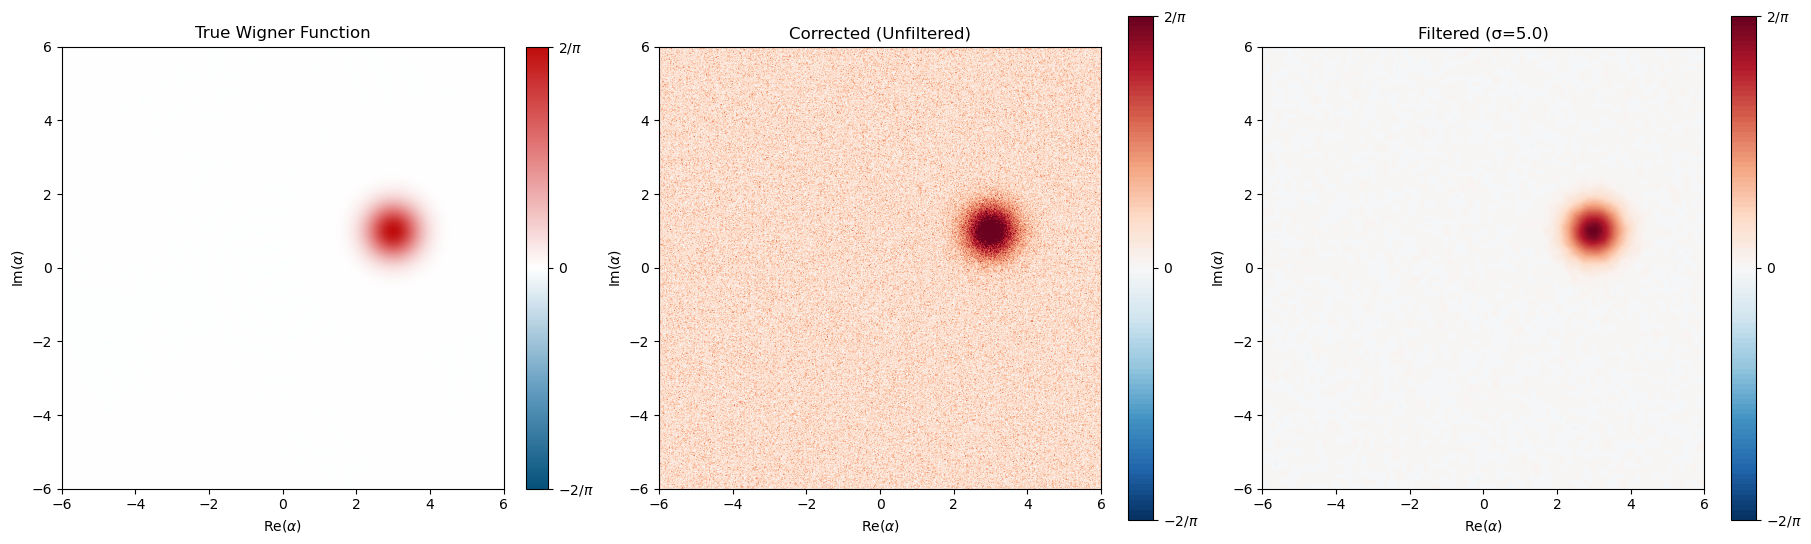

fidelity unbiased = 0.9695944786071777, fidelity after filtering = 0.9695944786071777
Case 5:  sacling a = 6.375e-01, bias b = -6.073e-01


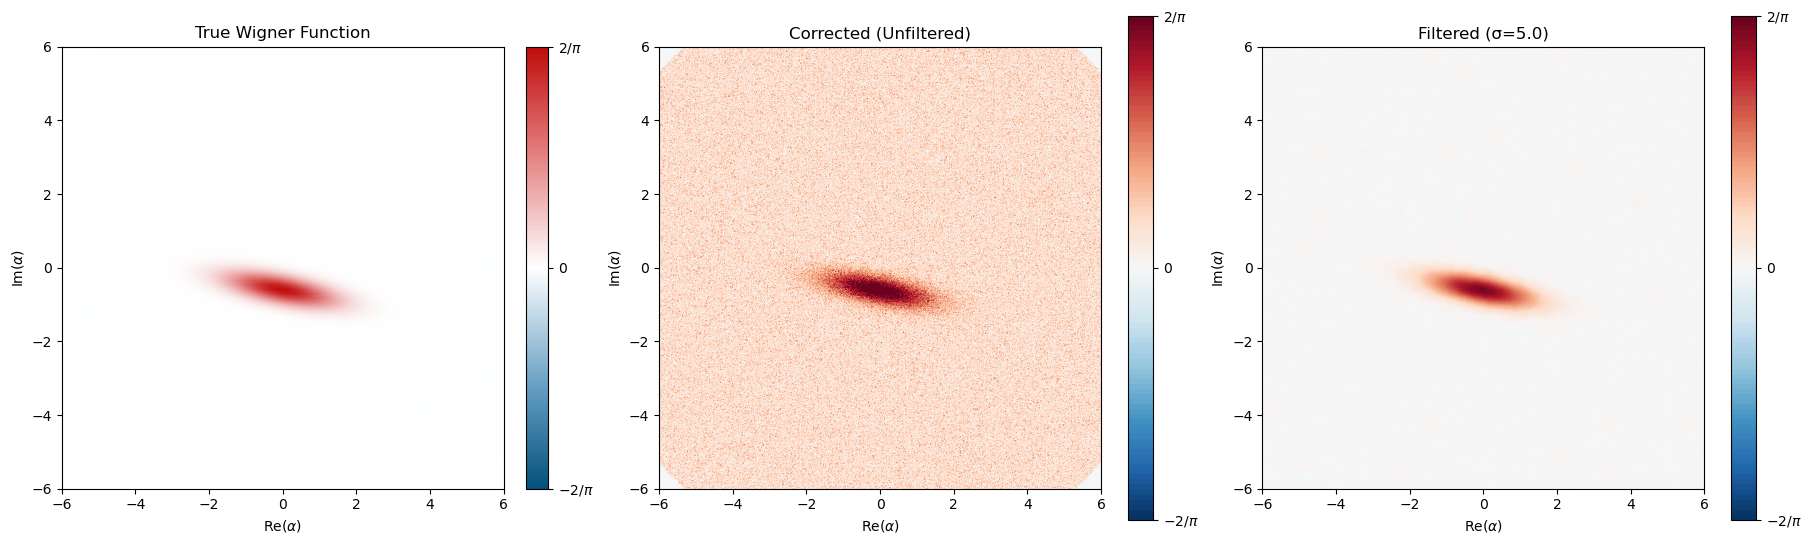

fidelity unbiased = 0.9863103032112122, fidelity after filtering = 0.9863103032112122
Case 6:  sacling a = 1.246e+00, bias b = 3.573e-01


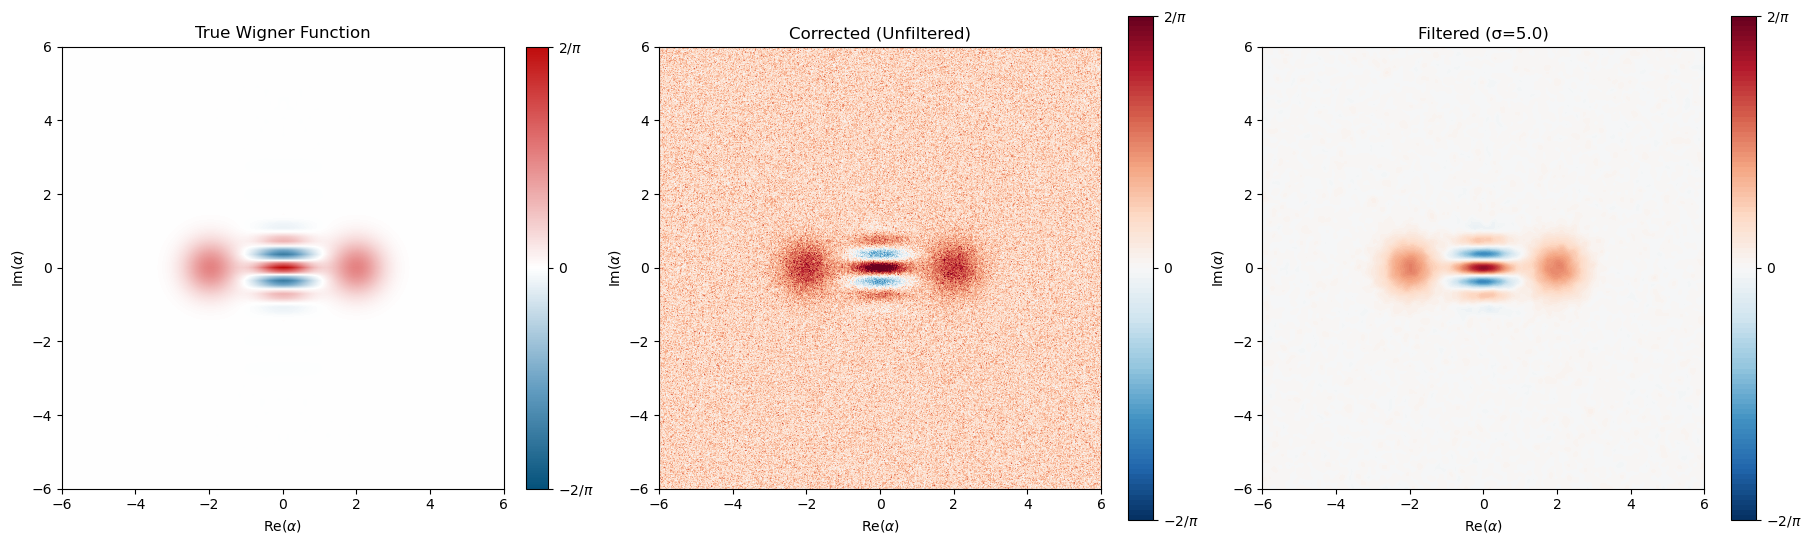

fidelity unbiased = 1.035402536392212, fidelity after filtering = 1.035402536392212
Case 7:  sacling a = 7.551e-01, bias b = -3.497e-01


In [ ]:
for i in range(8):
    #load noisy Wigner
    wigner_function_filename = f'data/synthetic/noisy_wigner_{i}.pickle'
    with open(wigner_function_filename, 'rb') as f:
        wigner_data = pickle.load(f)
    x_values, y_values, wigner_values = [np.array(part) for part in wigner_data]
    
    #load the “true” quantum state for plotting
    quantum_state_filename = f'data/synthetic/quantum_state_{i}.pickle'
    with open(quantum_state_filename, 'rb') as f:
        quantum_state_data = pickle.load(f)

    #affine correction
    corrected_wigner,a,b = rescale_wigner(x_values, y_values, wigner_values)

    fid_unbiased  = get_denoising_fidelity(
        corrected_wigner,
        x_values = x_values,
        y_values = y_values,
        noiseless_quantum_state = quantum_state_data
        )

    #apply 2D Gaussian filter
    sigma = 5.0            # <-- try different values
    filtered_wigner = gaussian_filter(corrected_wigner, sigma=sigma)

    fid_filtered = get_denoising_fidelity(
        corrected_wigner,
        x_values = x_values,
        y_values = y_values,
        noiseless_quantum_state= quantum_state_data)

    print(f'fidelity unbiased = {fid_unbiased}, fidelity after filtering = {fid_filtered}')

    print(f'Case {i}:  sacling a = {a:.3e}, bias b = {b:.3e}')

    #now plot side‐by‐side
    fig, axs = plt.subplots(1, 3,figsize=(18, 5.5),constrained_layout=True)   

    # 1) true Wigner
    dq.plot.wigner(quantum_state_data, ax=axs[0], xmax=6, ymax=6, colorbar=True)
    axs[0].set_title('True Wigner Function')

    # 2) corrected but unfiltered
    levels = np.linspace(-2/np.pi, 2/np.pi, 101)
    cf0 = axs[1].contourf(
        x_values, y_values, corrected_wigner.T,
        levels=levels, cmap='RdBu_r'
    )
    cbar = fig.colorbar(cf0, ax=axs[1], ticks=[-2/np.pi, 0, 2/np.pi])
    cbar.ax.set_yticklabels([r'$-2/\pi$', r'$0$', r'$2/\pi$'])
    axs[1].set_title('Corrected (Unfiltered)')

    # 3) corrected + Gaussian‐filtered
    cf1 = axs[2].contourf(
        x_values, y_values, filtered_wigner.T,
        levels=levels, cmap='RdBu_r'
    )
    cbar =fig.colorbar(cf1, ax=axs[2], ticks=[-2/np.pi, 0, 2/np.pi])
    cbar.ax.set_yticklabels([r'$-2/\pi$', r'$0$', r'$2/\pi$'])
    axs[2].set_title(f'Filtered (σ={sigma})')

    for ax in axs:
        ax.set_xlabel(r'Re($\alpha$)')
        ax.set_ylabel(r'Im($\alpha$)')
        ax.set_aspect('equal', adjustable='box')

    plt.show()